In [1]:
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, optimizers
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import numpy as np
from sklearn.metrics import *
from tensorflow.keras import callbacks
import seaborn as sns
import matplotlib.pyplot as plt

2024-06-27 16:40:50.066118: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [25]:
def training(xtr,ytr,xval,yval,cw):
    org_model = keras.models.load_model("../modelsave/weightmodel")
    org_model = models.Model(inputs=org_model.input, outputs=org_model.get_layer('dense_6').output) # do not include final classifier
    org_model.summary()

    org_model.trainable = False
    inputs = keras.Input(shape=(2869,1))
    x = org_model(inputs, training=False)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.summary()
    
    earlystopping = callbacks.EarlyStopping(monitor ="val_accuracy", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

    model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
    model.fit(xtr, ytr, batch_size=10, epochs=20,validation_data=(xval, yval),
                   shuffle=True,class_weight=cw)

    org_model.trainable = True
    model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
                  loss=keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[keras.metrics.BinaryAccuracy()])

    
    model.fit(xtr, ytr, batch_size=10, epochs=50,validation_data=(xval, yval),
                   shuffle=True,class_weight=cw,callbacks =[earlystopping])
    return model

In [4]:
rna_idx=pd.read_csv("../data/dataBulk/common_rna.csv",index_col=0).values.squeeze().tolist()

# prepare training data
files=["26440","57065","95233","4607","8121","9692","13904","26378","28750"]

datasets = []
labels = []

for file in files:
    
    if file == "13904":
        df=pd.read_csv("../data/dataBulk/exp.gene.mRNA.GSE"+file+'.txt' , sep="\t").T
        df_label=pd.read_csv("../data/dataBulk/label_GSE"+file+'.txt' , sep="\t",header=None)
        data=df[rna_idx].T
        data=data[df_label[0]].T.values
        label=df_label[2].values>0
    else:
        df=pd.read_csv("../data/dataBulk/exp.gene.mRNA.GSE"+file+'.txt' , sep="\t").T
        data=df[rna_idx].values
        df_label=pd.read_csv("../data/dataBulk/label_GSE"+file+'.txt' , sep="\t",header=None)[2].values
        label=(df_label>0)
    
    datasets.append(data)
    labels.append(label)
datasets

[array([[ 5.686 , 11.3806,  7.1689, ..., 10.6627,  9.3806,  5.5011],
        [ 5.3899, 11.3008,  7.8225, ..., 10.7067,  9.8158,  4.895 ],
        [ 5.2863,  8.4467,  7.775 , ..., 10.7362,  7.3991,  4.7524],
        ...,
        [ 5.9418,  7.851 ,  8.5398, ...,  9.8227,  7.0775,  4.8467],
        [ 5.7863,  9.6025,  8.8713, ..., 10.5933,  7.2535,  5.5077],
        [ 5.0932,  8.5812,  7.9627, ..., 11.3954,  6.7701,  4.8525]]),
 array([[ 4.1258,  8.4825,  7.375 , ...,  9.9011,  9.977 ,  4.5518],
        [ 3.7253,  7.0136,  7.3436, ...,  9.974 , 10.9023,  4.3127],
        [ 4.1171,  7.4553,  7.5396, ...,  9.8454, 10.3504,  4.6858],
        ...,
        [ 4.6867,  8.0777,  7.48  , ...,  9.57  , 10.7467,  4.8751],
        [ 4.5665,  8.339 ,  6.8913, ...,  9.6997, 10.374 ,  4.1515],
        [ 4.4886,  7.878 ,  7.3   , ...,  9.3813, 10.6168,  4.6568]]),
 array([[ 4.6275,  7.793 ,  4.8201, ...,  9.5678, 10.3472,  4.2763],
        [ 4.3328,  6.8776,  4.857 , ..., 10.0162, 10.9576,  4.2889],
    

In [23]:
###把bulk数据真实label导出来
for label, file in zip(labels, files):
    filename = f"GSE{file}_truelabel.csv"
    df = pd.DataFrame({"label": label})
    df.to_csv(f"../data/dataBulk/bulk_truelabel/{filename}", index=False)

In [50]:
results = []
pred = []
for dataset, label, training_cohort in zip(datasets,labels,files):
    xtr,xval, ytr,yval = train_test_split(dataset,label,test_size=0.2,random_state=42)

    cw = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(ytr),y=ytr)
    cw = {0:cw[0],1:cw[1]}
    
    model = training(xtr,ytr,xval,yval,cw)
    print("training cohort: GSE", training_cohort)
    
    test_result = []
    #testresult = []
    for x_test,y_test, test_cohort in zip(datasets,labels,files):
        testresult=model.predict(x_test)
        fpr, tpr, _ = roc_curve(y_test,testresult)
        roc_auc = auc(fpr,tpr)
        #print("test cohort GSE", test_cohort, "AUC:", roc_auc)
        test_result.append(roc_auc)
        print(testresult)
        pred.append(testresult)   
    results.append(test_result)

Model: "model_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2869, 1)]         0         
_________________________________________________________________
weightlayer (Weightlayer)    ((None, 2869, 8), (1, 286 22952     
_________________________________________________________________
primarycap_reshape (Reshape) (None, 2869, 8)           0         
_________________________________________________________________
primarycap_squash (Lambda)   (None, 2869, 8)           0         
_________________________________________________________________
groupcaps (CapsuleLayer)     ((None, 20, 16), (None, 2 7344640   
_________________________________________________________________
transformer_block (Transform (None, 20, 16)            5392      
_________________________________________________________________
flatten (Flatten)            (None, 320)               0  

In [51]:
len(pred)

81

In [59]:
###把bulk数据预测label导出来
for label, file in zip(pred[:9], files):
    filename = f"GSEGSE26440-{file}_predlabel.csv"
    #df = pd.DataFrame({"label": label})
    np.savetxt(f"../data/dataBulk/bulk_predlabel/{filename}", label, delimiter=',')

In [60]:
###把bulk数据预测label导出来
for label, file in zip(pred[9:18], files):
    filename = f"GSE57065-{file}_predlabel.csv"
    #df = pd.DataFrame({"label": label})
    np.savetxt(f"../data/dataBulk/bulk_predlabel/{filename}", label, delimiter=',')

In [61]:
###把bulk数据预测label导出来
for label, file in zip(pred[18:27], files):
    filename = f"GSE95233-{file}_predlabel.csv"
    #df = pd.DataFrame({"label": label})
    np.savetxt(f"../data/dataBulk/bulk_predlabel/{filename}", label, delimiter=',')

In [66]:
###把bulk数据预测label导出来
for label, file in zip(pred[27:36], files):
    filename = f"GSE4607-{file}_predlabel.csv"
    #df = pd.DataFrame({"label": label})
    np.savetxt(f"../data/dataBulk/bulk_predlabel/{filename}", label, delimiter=',')

In [67]:
###把bulk数据预测label导出来
for label, file in zip(pred[36:45], files):
    filename = f"GSE8121-{file}_predlabel.csv"
    #df = pd.DataFrame({"label": label})
    np.savetxt(f"../data/dataBulk/bulk_predlabel/{filename}", label, delimiter=',')

In [68]:
###把bulk数据预测label导出来
for label, file in zip(pred[45:54], files):
    filename = f"GSE9692-{file}_predlabel.csv"
    #df = pd.DataFrame({"label": label})
    np.savetxt(f"../data/dataBulk/bulk_predlabel/{filename}", label, delimiter=',')

In [69]:
###把bulk数据预测label导出来
for label, file in zip(pred[54:63], files):
    filename = f"GSE13904-{file}_predlabel.csv"
    #df = pd.DataFrame({"label": label})
    np.savetxt(f"../data/dataBulk/bulk_predlabel/{filename}", label, delimiter=',')

In [70]:
###把bulk数据预测label导出来
for label, file in zip(pred[63:72], files):
    filename = f"GSE26378-{file}_predlabel.csv"
    #df = pd.DataFrame({"label": label})
    np.savetxt(f"../data/dataBulk/bulk_predlabel/{filename}", label, delimiter=',')

In [71]:
###把bulk数据预测label导出来
for label, file in zip(pred[72:81], files):
    filename = f"GSE28750-{file}_predlabel.csv"
    #df = pd.DataFrame({"label": label})
    np.savetxt(f"../data/dataBulk/bulk_predlabel/{filename}", label, delimiter=',')

In [28]:
cohort_name = ['GSE' + name for name in files]
df_results = pd.DataFrame(results, index = cohort_name, columns = cohort_name)
df_results

,GSE26440,GSE57065,GSE95233,GSE4607,GSE8121,GSE9692,GSE13904,GSE26378,GSE28750
GSE26440,0.999043,1.000000,1.000000,0.988272,0.973333,0.995556,0.883547,0.990708,1.00
GSE57065,0.998406,1.000000,0.999554,0.991975,0.893333,0.957778,0.841880,1.000000,1.00
GSE95233,0.994898,1.000000,1.000000,0.977160,0.954444,0.971111,0.948718,0.996516,1.00
GSE4607,0.999362,0.996585,0.996881,0.987654,0.877778,0.884444,0.740385,0.990128,1.00
GSE8121,0.926339,0.976585,0.988414,0.929630,0.985556,0.953333,0.943376,0.932636,0.97
GSE9692,0.984056,0.964390,0.962121,0.972222,0.985556,1.000000,0.994658,0.937282,0.96
GSE13904,0.969069,0.980000,0.945633,0.971605,0.985556,1.000000,1.000000,0.944251,0.95
GSE26378,0.998724,1.000000,1.000000,0.987654,0.812222,0.777778,0.559829,0.999419,1.00
GSE28750,0.991390,0.995122,0.995989,0.975926,0.991111,0.957778,0.846154,0.992451,1.00


#  Plot

In [2]:
df__ = pd.read_csv('../figures/data/rotatingTest.csv',index_col=0)
df__

,GSE26440,GSE57065,GSE95233,GSE4607,GSE8121,GSE9692,GSE13904,GSE26378,GSE28750
GSE26440,0.998406,1.000000,0.998217,0.986420,0.981111,0.997778,0.961538,0.992451,1.000
GSE57065,0.999362,1.000000,1.000000,0.989506,0.908889,0.902222,0.858974,0.998258,1.000
GSE95233,0.994898,0.999512,1.000000,0.987037,0.917778,0.966667,0.920940,0.997677,1.000
GSE4607,0.997130,0.998049,0.996881,0.987654,0.991111,0.971111,0.935897,0.984321,1.000
GSE8121,0.825574,0.947805,0.977718,0.831173,0.992222,0.982222,0.973291,0.878049,0.840
GSE9692,0.989477,0.989268,0.995098,0.976543,0.985556,1.000000,0.977564,0.958769,1.000
GSE13904,0.975128,0.968780,0.974153,0.969753,0.985556,1.000000,1.000000,0.926829,0.965
GSE26378,0.998406,1.000000,1.000000,0.988272,0.932222,0.966667,0.840812,1.000000,1.000
GSE28750,0.997768,0.999512,0.998663,0.983333,0.860000,0.906667,0.821581,0.990708,1.000


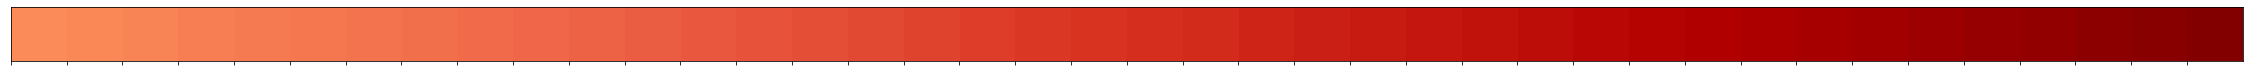

In [2]:
# sns.palplot(sns.color_palette("OrRd_r", 20)) 
new_c=sns.color_palette("OrRd", 80)[40:80]
sns.palplot(new_c)

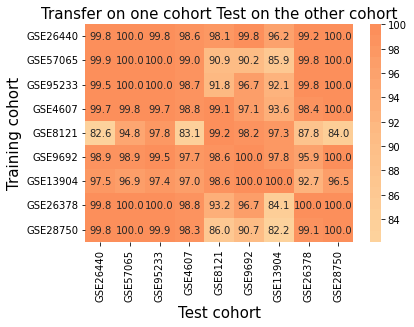

In [93]:
hm_plot = sns.heatmap(df__*100, annot=True, fmt=".1f", cmap=new_c)
hm_plot.set_xlabel('Test cohort', fontsize=15)
hm_plot.set_ylabel('Training cohort', fontsize=15)
hm_plot.set_title('Transfer on one cohort Test on the other cohort', fontsize = 15)
fig = hm_plot.get_figure()
fig.savefig('../figures/rotate_test.png', bbox_inches='tight',dpi=600)

<AxesSubplot:>

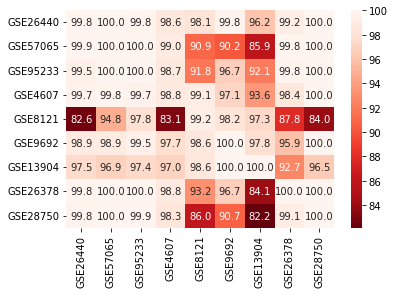

In [73]:
sns.heatmap(df__*100, annot=True, fmt=".1f", cmap="Reds_r")